In [4]:
from pymongo import MongoClient

# Verbindung zur MongoDB-Datenbank herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")

# Datenbank und Sammlung auswählen
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Beispielabfrage
for document in collection.find():
    print(document)

Num GPUs Available:  1


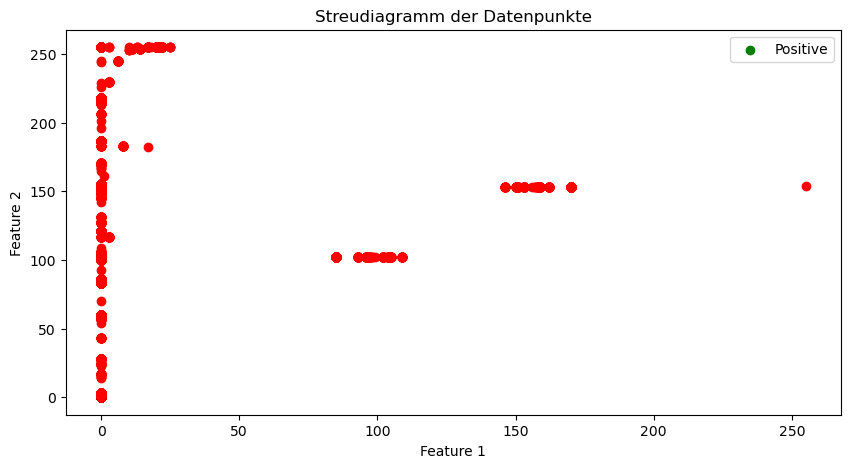

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pymongo
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import tensorflow as tf

# Überprüfen, ob die GPU verfügbar ist
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    base64_data = base64_string.split(",")[1]
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername
username = "username_1"

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

for other_user in collection.find({"username": {"$ne": username}}):
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Streudiagramm der Datenpunkte
plt.figure(figsize=(10, 5))
for i in range(len(y)):
    if y[i] == 1:
        plt.scatter(X[i, 0], X[i, 1], color='green', label='Positive' if i == 0 else "")
    else:
        plt.scatter(X[i, 0], X[i, 1], color='red', label='Negative' if i == 0 else "")
plt.title('Streudiagramm der Datenpunkte')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


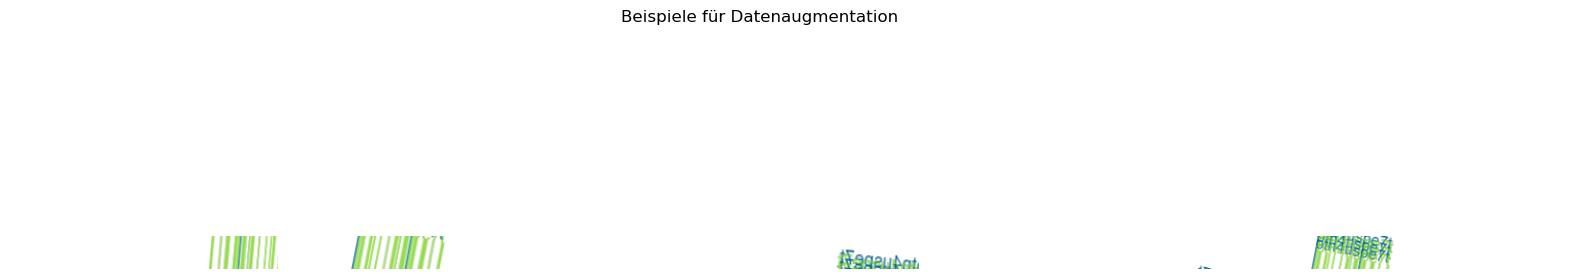

In [2]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)
# Visualisierung der Datenaugmentation
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    augmented_image = datagen.random_transform(X_train[0])
    ax.imshow(augmented_image.astype('uint8'))
    ax.axis('off')
plt.suptitle('Beispiele für Datenaugmentation')
plt.show()

In [4]:
def create_improved_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

input_shape = X_train.shape[1:]
model = create_improved_cnn_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
110/110 [==============================] - 18s 108ms/step - loss: 0.8309 - accuracy: 0.5494 - val_loss: 0.7117 - val_accuracy: 0.5386
Epoch 2/50
110/110 [==============================] - 11s 103ms/step - loss: 0.6888 - accuracy: 0.5696 - val_loss: 0.6907 - val_accuracy: 0.5386
Epoch 3/50
110/110 [==============================] - 12s 105ms/step - loss: 0.6874 - accuracy: 0.5753 - val_loss: 0.6902 - val_accuracy: 0.5386
Epoch 4/50
110/110 [==============================] - 11s 102ms/step - loss: 0.6885 - accuracy: 0.5741 - val_loss: 0.6905 - val_accuracy: 0.5386
Epoch 5/50
110/110 [==============================] - 11s 100ms/step - loss: 0.6887 - accuracy: 0.5756 - val_loss: 0.6904 - val_accuracy: 0.5386
Epoch 6/50
110/110 [==============================] - 11s 101ms/step - loss: 0.6861 - accuracy: 0.5761 - val_loss: 0.6903 - val_accuracy: 0.5386
Epoch 7/50
110/110 [==============================] - 11s 100ms/step - loss: 0.6840 - accuracy: 0.5756 - val_loss: 0.6904 - val_ac

KeyboardInterrupt: 

In [ ]:
# Trainings- und Validierungsgenauigkeit plotten
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()

# Trainings- und Validierungsverlust plotten
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()

plt.show()


In [ ]:
def create_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

models = [create_model_1(input_shape), create_model_2(input_shape)]
model_names = ['Model 1', 'Model 2']
results = []

for model, name in zip(models, model_names):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])
    y_pred = model.predict(X_test)
    accuracy = np.mean((y_pred > 0.5).astype(int) == y_test)
    results.append({'Model': name, 'Accuracy': accuracy})

# Ergebnisse in einem DataFrame anzeigen
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Modellvergleich')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.show()
